In [3]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from typing import TypedDict,Annotated,Literal
from dotenv import load_dotenv
from langgraph.graph.state import LastValue
from langgraph.checkpoint.memory import InMemorySaver
load_dotenv()
import os
groq_api_key=os.getenv("GROQ_API_KEY")

In [5]:
class Jokestate(TypedDict):

    topic:str
    joke:str
    explanation:str

In [6]:
graph=StateGraph(Jokestate)

In [7]:
checkpointer=InMemorySaver()

In [8]:
model=ChatGroq(model="llama-3.1-8b-instant" ,temperature=0.3,max_tokens=100,api_key=groq_api_key)

In [9]:
def genrate_joke(state : Jokestate):

    prompt=f'genrate the joke on given topic - {state['topic']}'

    joke=model.invoke(prompt).content

    return {
        **state,
        'joke':joke
    }

In [10]:
def genrate_explanation(state :Jokestate):

    prompt=f'give the explanation of followig joke -{state['joke']}'

    explanation=model.invoke(prompt).content

    return {
        **state,
        'explanation':explanation
    }

In [11]:
graph.add_node('genrate_joke',genrate_joke)
graph.add_node('genrate_explanation',genrate_explanation)

In [12]:
graph.add_edge(START,'genrate_joke')
graph.add_edge('genrate_joke','genrate_explanation')
graph.add_edge('genrate_explanation',END)

In [13]:
chatbot=graph.compile(checkpointer=checkpointer)

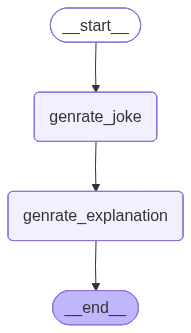

In [14]:
chatbot

In [15]:
config1 = {"configurable": {"thread_id": "1"}}
intial_state={
    'topic':'samosa'
}

final_state=chatbot.invoke(intial_state,config=config1)

In [16]:
print(final_state['joke'])

Why did the samosa go to therapy?

Because it was feeling crumby and had a lot of folded emotions.


In [17]:
chatbot.get_state(config1)

StateSnapshot(values={'topic': 'samosa', 'joke': 'Why did the samosa go to therapy?\n\nBecause it was feeling crumby and had a lot of folded emotions.', 'explanation': 'The joke is a play on words, using the multiple meanings of "crumby" and "folded emotions" to create a pun.\n\n- "Crumby" has a double meaning here. It can refer to something that is of poor quality or in a bad state, but it also refers to the fact that a samosa is a type of pastry that is typically made with a crumbly or flaky dough. So, the samosa is feeling "crumby" in'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0fea76-3590-6414-8002-a3ce45d6d754'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-31T13:18:52.825602+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0fea76-329e-6fc7-8001-7fd68a518b65'}}, tasks=(), interrupts=())

In [18]:
list(chatbot.get_state_history(config=config1))

[StateSnapshot(values={'topic': 'samosa', 'joke': 'Why did the samosa go to therapy?\n\nBecause it was feeling crumby and had a lot of folded emotions.', 'explanation': 'The joke is a play on words, using the multiple meanings of "crumby" and "folded emotions" to create a pun.\n\n- "Crumby" has a double meaning here. It can refer to something that is of poor quality or in a bad state, but it also refers to the fact that a samosa is a type of pastry that is typically made with a crumbly or flaky dough. So, the samosa is feeling "crumby" in'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0fea76-3590-6414-8002-a3ce45d6d754'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-31T13:18:52.825602+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0fea76-329e-6fc7-8001-7fd68a518b65'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'topic': 'samosa', 'joke': 'Why did the

In [19]:
#  persistance means store the at each node state and restore it
# fault tolereance mean resume from where it crashed
# human in loop which take the input from human 
# time trael from starting to end and create a new branch 

In [20]:
config2={
    'configurable':{'thread_id':'2'}
}
chatbot.invoke({'topic':'pizza'},config=config2)

{'topic': 'pizza',
 'joke': 'Here are a few pizza-themed jokes:\n\n1. Why was the pizza in a bad mood? \n   Because it was feeling a little crusty.\n\n2. Why did the pizza go to the doctor? \n   Because it was feeling a little saucy.\n\n3. Why did the pizza delivery guy break up with his girlfriend? \n   Because she was always trying to topping him.\n\n4. Why did the pizza go to therapy? \n   Because it was struggling to find its crust.\n\n5',
 'explanation': 'I\'ll explain the jokes for you:\n\n1. **Why was the pizza in a bad mood? Because it was feeling a little crusty.**\n\nThis joke plays on the double meaning of the word "crusty." In one sense, a pizza crust is the outer layer of a pizza. However, "crusty" can also describe someone who is irritable or in a bad mood. The joke is saying that the pizza is feeling irritable because it\'s "crusty," but also referencing'}

# Fault tolerance


In [4]:
import time 
class Faultolerance(TypedDict):

    input:str
    step1:str
    step2:str
    step3:str  

In [4]:
def step1(state :Faultolerance)->Faultolerance:
    print("step 1 executed..🛞")

    return {
        **state,
        'input':state['input'],
        'step1':'done'
    }

def step2(state: Faultolerance)-> Faultolerance:
    print("step 2 is executing... and we crashed manullay")
    time.sleep(30)
    return {
        **state,
        'step2':'done'
    }

def step3(state:Faultolerance)->Faultolerance:
    print("step 3 is executing ...")

    return {
        **state,
        'step3':'done'
    }



In [5]:
builder=StateGraph(Faultolerance)

In [6]:
builder.add_node('step1',step1)
builder.add_node('step2',step2)
builder.add_node('step3',step3)

In [7]:
builder.add_edge(START,'step1')
builder.add_edge('step1','step2')
builder.add_edge('step2','step3')
builder.add_edge('step3',END)

In [8]:
checkpointer2=InMemorySaver()

In [9]:
graph=builder.compile(checkpointer=checkpointer2)

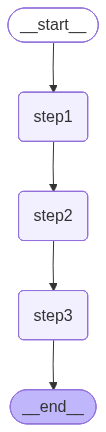

In [12]:
graph

In [14]:
try:
    print("▶️ Running graph: Please manually interrupt during Step 2...")
    graph.invoke({"input": "start"}, config={"configurable": {"thread_id": 'thread-1'}})
except KeyboardInterrupt:
    print("❌ Kernel manually interrupted (crash simulated).")

▶️ Running graph: Please manually interrupt during Step 2...
step 1 executed..🛞
step 2 is executing... and we crashed manullay
❌ Kernel manually interrupted (crash simulated).
